In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import base_features
import pitch_features
import rhythm_features
import feature_transforms
import utils

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Catchy feature extraction

## Outline

In this notebook, we compute CATCHY features for the full set of presegmented HookedOnMusic audio files.

As in `hooked30_demo` (in which we extracted the same features for just 30 segments), extracting catchy features from a folder of such files involves three steps:

#### 1. Base feature extraction

Here, basic, familiar feature time series are extracted. The toolbox currently implements (wrappers for) MFCC, chroma, melody and perceptual feature extraction.

This part of the toolbox relies on a lot of external code, but it's also easy to work around: if you want to use other features, just save them to a set of csv files (1 per song section--see below) in some folder (1 per feature).

#### 2. Pitch descriptor extraction
This part computes mid-level pitch descriptors from chroma and/or melody information computed in step one.
Essentially an implementation of several kinds of audio bigram descriptors.

See also [1] and [2].

#### 3. Feature transforms
Compute 'first' and 'second order' aggregates of any of the features computed in step 1 and step 2.

See [2].

[1] Van Balen, J., Wiering, F., & Veltkamp, R. (2015). Audio Bigrams as a Unifying Model of Pitch-based Song Description. In Proc. 11th International Symposium on Computer Music Multidisciplinary Research (CMMR). Plymouth, United Kingdom.

[2] Van Balen, J., Burgoyne, J. A., Bountouridis, D., Müllensiefen, D., & Veltkamp, R. (2015). Corpus Analysis Tools for Computational Hook Discovery. In Proc. 16th International Society for Music Information Retrieval Conference (pp. 227–233). Malaga, Spain.

## Dataset

Let's import some audio data and see how all of this works.

The CATCHY toolbox was designed for the analysis of a corpus of song *sections*.

CATCHY requires data to be represented as a python dictionary of song section paths, grouped by song id.

`utils.dataset_from_dir()` makes such a dictionary given a folder of audio files, labeled `songid-sectionid.ext` where `ext` can be `wav` or `mp3`

In [2]:
audio_dir = '../../Cogitch/Audio/HookedOnMusic_wav/'

## Base features

Basic feature time series can be extracted using the `base_features` module.
The function `compute_and_write()` provides a convenient wrapper around most of the functionality in this module, reading audio and computing a set of basic, useful features.

The results will be written to a set of csv files in `data_dir`.

Currently requires a dir to made for each of the features.

In [3]:
data_dir = '../../Cogitch/Data/HookedOnMusic/features/'

# best to pass on absolute paths when you're going to be doing makedirs()
data_dir = os.path.abspath(data_dir)

In [4]:
reload(base_features);
# base_features.compute_and_write(audio_dir, data_dir)

<module 'base_features' from 'base_features.pyc'>

## Pitch Features


The `pitch_features` module provides code to compute, from the variable-length base features computed above, fixed-sized melody and harmony descriptors for each of the song sections.

`pitch_features.compute_and_write()` again provides a high-level wrapper function.
The features that it should compute must be provided in a dictionary of `(feature_function, parameters)` tuples, with some feature name of your choice for each as keys.

The result is again stored in a set of csv files. Directories are the feature names provided.

In [5]:
reload(pitch_features);

pitch_features.melody_dir = os.path.join(data_dir, 'melody/')
pitch_features.chroma_dir = os.path.join(data_dir, 'hpcp/')

features = {'pitchhist3': (pitch_features.get_pitchhist3, {}),
            'pitchhist3_int': (pitch_features.get_pitchhist3, {'intervals': True}),
            'chromahist3': (pitch_features.get_chromahist3, {}),
            'chromahist3_int': (pitch_features.get_chromahist3, {'intervals': True}),
            'harmonisation': (pitch_features.get_harmonisation, {}),
            'harmonisation_int': (pitch_features.get_harmonisation, {'intervals': True}) }

# pitch_features.compute_and_write(data_dir, features=features)

## Rhythm features

The `rhythm_features` module computes histogram-like features on top of the beat and inter-onset-interval time series. Also computes raw and normalized `pvi` (pairwise variability index) features.

In [6]:
reload(rhythm_features)

rhythm_features.beats_dir = os.path.join(data_dir, 'beats/')
rhythm_features.onsets_dir = os.path.join(data_dir, 'onsets/')

features = {'tempo': (rhythm_features.local_tempo, {}),
            'log_norm_ioi': (rhythm_features.log_ioi, {'normalize_ioi': True}),
            'log_norm_ioi_hist': (rhythm_features.ioi_histogram, {'min_length': -3, 'max_length': 3, 'step': 0.5}),
            'ioii': (rhythm_features.ioii, {'normalize_ioi': False})}

rhythm_features.compute_and_write(data_dir, features=features)

Computing features for track 147533905...
making new dir /Users/Jan/Documents/Work/Cogitch/Data/HookedOnMusic/features/ioii
making new dir /Users/Jan/Documents/Work/Cogitch/Data/HookedOnMusic/features/log_norm_ioi
making new dir /Users/Jan/Documents/Work/Cogitch/Data/HookedOnMusic/features/log_norm_ioi_hist
Computing features for track 147527085...
Computing features for track 147533901...
Computing features for track 147531320...
Computing features for track 147530635...
Computing features for track 147529666...
Computing features for track 147530226...
Computing features for track 147528668...
Computing features for track 147530224...
Computing features for track 147529790...
Computing features for track 147533463...
Computing features for track 147534235...
Computing features for track 147528661...
Computing features for track 147531606...
Computing features for track 147529798...
Computing features for track 147527931...
Computing features for track 147534335...
Computing features 

### Quick sanity check of the new rhythm features' distributions

(skip for now)

In [7]:
# feat_dir = os.path.join(data_dir, 'log_norm_ioi_hist')
# track_ids = [filename.split('.')[0] for filename in os.listdir(feat_dir)]

# params = features['log_norm_ioi_hist'][1]
# nbins = (params['max_length'] - params['min_length']) / params['step'] + 1
# bincenters = np.linspace(params['min_length'], params['max_length'], nbins)

# for track_id in track_ids:
#     feat_file = os.path.join(feat_dir, track_id)
#     ioi_hist = utils.read_feature(feat_file)
#     plt.plot(bincenters, ioi_hist)

## Feature Transforms

The `feature_transforms` module allows you to compute first- and second-order features based on any of the features above. The transforms to be applied must be passed to the `compute()` function using a special syntax. The syntax states a feature, a reference corpus, and an aggregation function.

From the doc string:

    - feature name and aggregates are separated by dots, e.g. 'mfcc.entropy'
    - feature name is first and contains no dots
    - first order and second order aggregates are separated by one of 2 keywords:
        'corpus' or 'song'

    Ex.:
    >>> parse_features('loudness.mean.song.pdf.log')
    ('loudness', ['mean'], ['song', 'pdf', 'log'])
    
The above shows how the transform names are read. In the example:

    `loudness.mean.song.pdf.log` 

computes the log of the probability density function of the distribution of the loudness features' mean within the song (i.e., across the sections of the song).


The result is returned in a Pandas dataframe.

In [8]:
irregs_file = '/Users/Jan/Documents/Work/Cogitch/Data/HookedOnMusic/irregularities.csv'

with open(irregs_file) as f:
    irregs = pd.read_csv(f, sep=',', header=None)
    irregs = list(irregs[0])
    
irregs

[717,
 761,
 772,
 790,
 942,
 999,
 1000,
 1001,
 1002,
 1003,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1040,
 1070,
 1096,
 1139]

In [9]:
hkd30 = [f.split('.')[0] for f in os.listdir(data_dir + '/loudness/')]
# hkd30

In [10]:
songid_file = '/Users/Jan/Documents/Work/Cogitch/Data/HookedOnMusic/soundcloud_ids.csv'

hkd30_dict_all = {}
with open(songid_file) as f:
    csv_data = pd.read_csv(f, sep=',')
    # this can be done more efficiently, but we're not expecting that much data
    for song in set(csv_data['song']):
        if song not in irregs:
            sections = csv_data['soundcloud'][csv_data['song'] == song]
#             hkd30_dict_all[song] = [str(s) for s in sections]
            hkd30_dict_all[song] = [str(s) for s in sections if str(s) in hkd30]
            
hkd30_dict = {k: hkd30_dict_all[k] for k in hkd30_dict_all if len(hkd30_dict_all[k]) > 2}
print(len(hkd30_dict_all), len(hkd30_dict))

hkd30_dict

245 236


{716: ['147526759', '147526764', '147526767', '147526770'],
 718: ['147526788', '147526790', '147526793', '147526796', '147526800'],
 719: ['147526802', '147526804', '147526810', '147526815', '147526819'],
 720: ['147526823', '147526825', '147526831', '147526834', '147526836'],
 721: ['147526839', '147526848', '147526851', '147526856'],
 722: ['147526858', '147526859', '147526860', '147526863', '147526865'],
 725: ['147526893', '147526895', '147526902', '147526906'],
 727: ['147526931', '147526935', '147526937'],
 729: ['147526940', '147526948', '147526952', '147526955', '147526959'],
 730: ['147526962', '147526968', '147526969', '147526973'],
 734: ['147527005', '147527009', '147527013', '147527016', '147527017'],
 735: ['147527019', '147527022', '147527026', '147527030', '147527034'],
 736: ['147527038', '147527041', '147527043'],
 737: ['147527046', '147527049', '147527053', '147527056', '147527058'],
 738: ['147527064', '147527067', '147527071', '147527075'],
 739: ['147527078', '1

First we tell the module where to look for base features.

Then, a set of tested first and second-order features is computed for the full dataset.

In [11]:
reload(feature_transforms)

feature_transforms.data_dir = data_dir

features = [
    'loudness.mean',
    'loudness.mean.corpus.pdf.rank.logit',
    'loudness.mean.song.pdf.rank.logit',
    'loudness.std',
    'loudness.std.corpus.pdf.rank.logit',
    'loudness.std.song.pdf.rank.logit',
    'sharpness.mean',
    'sharpness.mean.corpus.pdf.rank.logit',
    'sharpness.mean.song.pdf.rank.logit',
    'roughness.mean.log',
    'roughness.mean.log.corpus.pdf.rank.logit',
    'roughness.mean.log.song.pdf.rank.logit',
    
    'mfcc.mean.corpus.indeppdf.rank.logit',
    'mfcc.mean.song.indeppdf.rank.logit',
    'mfcc.totvar.log',
    'mfcc.totvar.log.corpus.pdf.rank.logit',
    'mfcc.totvar.log.song.pdf.rank.logit',
    
    'melody.mean',
    'melody.mean.corpus.pdf.rank.logit',
    'melody.mean.song.pdf.rank.logit',
    'melody.std.log',
    'melody.std.log.corpus.pdf.rank.logit',
    'melody.std.log.song.pdf.rank.logit',
    
    'pitchhist3_int.corpus.information',
    'pitchhist3_int.corpus.tau',
    'pitchhist3_int.song.information',
    'pitchhist3_int.song.tau',
    'pitchhist3_int.normentropy.minlog',
    'pitchhist3_int.normentropy.minlog.corpus.pdf.rank.logit',
    'pitchhist3_int.normentropy.minlog.song.pdf.rank.logit',
    'chromahist3_int.corpus.information',
    'chromahist3_int.corpus.tau',
    'chromahist3_int.song.information',
    'chromahist3_int.song.tau',
    'chromahist3_int.normentropy.minlog',
    'chromahist3_int.normentropy.minlog.corpus.pdf.rank.logit',
    'chromahist3_int.normentropy.minlog.song.pdf.rank.logit',
    'harmonisation_int.corpus.information',
    'harmonisation_int.corpus.tau',
    'harmonisation_int.song.information',
    'harmonisation_int.song.tau',
    'harmonisation_int.normentropy.minlog',
    'harmonisation_int.normentropy.minlog.corpus.pdf.rank.logit',
    'harmonisation_int.normentropy.minlog.song.pdf.rank.logit',

    'log_norm_ioi.mean',
    'log_norm_ioi.mean.corpus.pdf.rank.logit',
    'log_norm_ioi.mean.song.pdf.rank.logit',
    'log_norm_ioi.std',
    'log_norm_ioi.std.corpus.pdf.rank.logit',
    'log_norm_ioi.std.song.pdf.rank.logit',

    'tempo.mean',
    'tempo.mean.corpus.pdf.rank.logit',
    'tempo.mean.song.pdf.rank.logit',
    'tempo.std',
    'tempo.std.corpus.pdf.rank.logit',
    'tempo.std.song.pdf.rank.logit',
    
    'log_norm_ioi_hist.corpus.information',
    'log_norm_ioi_hist.corpus.tau',
    'log_norm_ioi_hist.song.information',
    'log_norm_ioi_hist.song.tau',
    'log_norm_ioi_hist.normentropy.minlog',
    'log_norm_ioi_hist.normentropy.minlog.corpus.pdf.rank.logit',
    'log_norm_ioi_hist.normentropy.minlog.song.pdf.rank.logit',
    
    # below should be equivalent to RPVI
    'ioii.mean',
    'ioii.mean.corpus.pdf.rank.logit',
    'ioii.mean.song.pdf.rank.logit',
]

data = feature_transforms.compute(hkd30_dict, features)

computing loudness.mean...
computing loudness.mean.corpus.pdf.rank.logit...
computing loudness.mean.song.pdf.rank.logit...
computing loudness.std...
computing loudness.std.corpus.pdf.rank.logit...
computing loudness.std.song.pdf.rank.logit...
computing sharpness.mean...
computing sharpness.mean.corpus.pdf.rank.logit...
computing sharpness.mean.song.pdf.rank.logit...
computing roughness.mean.log...
computing roughness.mean.log.corpus.pdf.rank.logit...
computing roughness.mean.log.song.pdf.rank.logit...
computing mfcc.mean.corpus.indeppdf.rank.logit...
computing mfcc.mean.song.indeppdf.rank.logit...
computing mfcc.totvar.log...
computing mfcc.totvar.log.corpus.pdf.rank.logit...
computing mfcc.totvar.log.song.pdf.rank.logit...
computing melody.mean...
computing melody.mean.corpus.pdf.rank.logit...
computing melody.mean.song.pdf.rank.logit...
computing melody.std.log...
computing melody.std.log.corpus.pdf.rank.logit...
computing melody.std.log.song.pdf.rank.logit...
computing pitchhist3_in

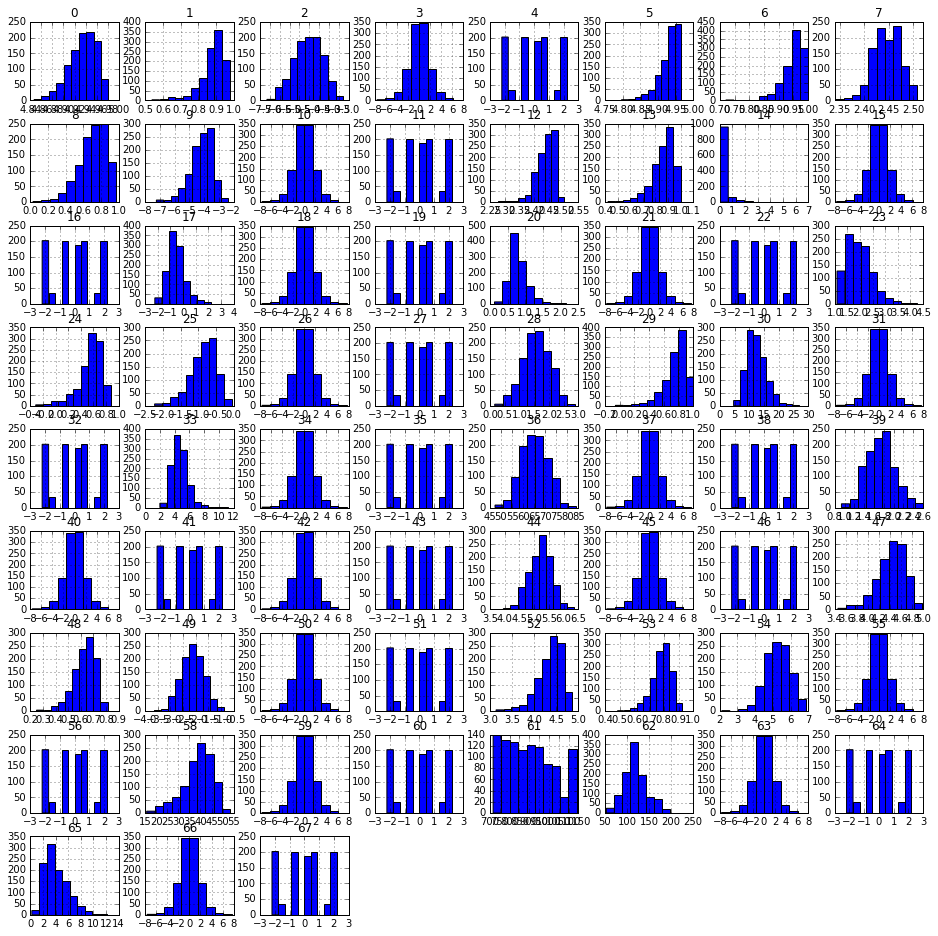

In [12]:
data_viz = data.copy()
data_viz.columns = range(len(data_viz.columns))
data_viz.hist(figsize=(16,16));

In [13]:
for col in data.columns:
    print(col)

chromahist3_int.corpus.information
chromahist3_int.corpus.tau
chromahist3_int.normentropy.minlog
chromahist3_int.normentropy.minlog.corpus.pdf.rank.logit
chromahist3_int.normentropy.minlog.song.pdf.rank.logit
chromahist3_int.song.information
chromahist3_int.song.tau
harmonisation_int.corpus.information
harmonisation_int.corpus.tau
harmonisation_int.normentropy.minlog
harmonisation_int.normentropy.minlog.corpus.pdf.rank.logit
harmonisation_int.normentropy.minlog.song.pdf.rank.logit
harmonisation_int.song.information
harmonisation_int.song.tau
ioii.mean
ioii.mean.corpus.pdf.rank.logit
ioii.mean.song.pdf.rank.logit
log_norm_ioi.mean
log_norm_ioi.mean.corpus.pdf.rank.logit
log_norm_ioi.mean.song.pdf.rank.logit
log_norm_ioi.std
log_norm_ioi.std.corpus.pdf.rank.logit
log_norm_ioi.std.song.pdf.rank.logit
log_norm_ioi_hist.corpus.information
log_norm_ioi_hist.corpus.tau
log_norm_ioi_hist.normentropy.minlog
log_norm_ioi_hist.normentropy.minlog.corpus.pdf.rank.logit
log_norm_ioi_hist.normentropy

In [16]:
rename_dict = {}
for col in data.columns:
    new_col = col
    # translating parts of feature names
    new_col = new_col.replace('chromahist3_int', 'harmony')
    new_col = new_col.replace('pitchhist3_int', 'melody')
    new_col = new_col.replace('harmonisation_int', 'harmonisation')
    new_col = new_col.replace('corpus.tau', 'conventionality')
    new_col = new_col.replace('corpus.pdf.rank.logit', 'conventionality')
    new_col = new_col.replace('song.tau', 'recurrence')
    new_col = new_col.replace('song.pdf.rank.logit', 'recurrence')
    new_col = new_col.replace('normentropy.minlog', 'negative entropy')
    new_col = new_col.replace('corpus.information', 'information | corpus')
    new_col = new_col.replace('song.information', 'information | song')
    new_col = new_col.replace('log_norm_ioi_hist', 'ioi histogram')
    new_col = new_col.replace('log_norm_ioi', 'log beatwise ioi')
    new_col = new_col.replace('ioii.mean', 'rpvi')
    new_col = new_col.replace('.', ' ')
    print(new_col)
    rename_dict[col] = new_col

data_csv = data.rename(columns=rename_dict)

# for col in data_csv.columns:
#     print(col)

harmony information | corpus
harmony conventionality
harmony negative entropy
harmony negative entropy conventionality
harmony negative entropy recurrence
harmony information | song
harmony recurrence
harmonisation information | corpus
harmonisation conventionality
harmonisation negative entropy
harmonisation negative entropy conventionality
harmonisation negative entropy recurrence
harmonisation information | song
harmonisation recurrence
rpvi
rpvi conventionality
rpvi recurrence
log beatwise ioi mean
log beatwise ioi mean conventionality
log beatwise ioi mean recurrence
log beatwise ioi std
log beatwise ioi std conventionality
log beatwise ioi std recurrence
ioi histogram information | corpus
ioi histogram conventionality
ioi histogram negative entropy
ioi histogram negative entropy conventionality
ioi histogram negative entropy recurrence
ioi histogram information | song
ioi histogram recurrence
loudness mean
loudness mean conventionality
loudness mean recurrence
loudness std
loudne

## Output

Finally, output data to a single CSV file for use in another notebook or R.

In [17]:
data_csv.to_csv(data_dir + '/all_features.csv', index=None)